In [1]:
import os

import dill
import matplotlib.pyplot as plt
import pandas as pd
import pyro
import seaborn as sns

pyro.settings.set(module_local_params=True)

sns.set_style("white")

# Set seed for reproducibility
seed = 123
pyro.clear_param_store()
pyro.set_rng_seed(seed)

import matplotlib.pyplot as plt
import seaborn as sns

from collab.foraging import locust as lc
from collab.utils import find_repo_root

root = find_repo_root()

smoke_test = "CI" in os.environ
num_iterations = 50 if smoke_test else 1500
num_samples = 20 if smoke_test else 150
starts = [0] if smoke_test else [0, 30, 60, 90]
diffs = (
    [4]
    if smoke_test
    else [2, 3, 4, 5, 6, 7, 8, 9, 10, 12, 14, 16, 18, 20, 30, 40, 50, 60, 70, 80]
)

In [2]:
data_code = "15EQ20191202"
validation_data_code = "15EQ20191205"


starts = []
ends = []
null_mses = []
model_mses = []
rsquareds = []

v_null_mses = []
v_model_mses = []
v_rsquareds = []


for start in starts:
    for end in [start + diff for diff in diffs]:
        starts.append(start)
        ends.append(end)
        print(start, end)

        locds = lc.LocustDS(
            data_code=data_code,
            start=start,
            end=end,
        )

        locds.run_inference(
            "length", num_iterations=num_iterations, num_samples=num_samples
        )

        for key in locds.init_state.keys():
            assert (
                locds.init_state[key].item() == locds.samples[key][0, 0, 0].item()
            ), "predictive inits are wrong"

        locds.evaluate()

        null_mses.append(locds.null_mse.numpy())
        model_mses.append(locds.mse_mean)
        rsquareds.append(locds.rsquared)

        if not smoke_test:
            locds.posterior_check()

        locds.validate(validation_data_code=validation_data_code)

        for key in locds.v_init_state.keys():
            assert (
                locds.v_init_state[key].item() == locds.v_samples[key][0, 0, 0].item()
            ), "validation inits are wrong"

        v_null_mses.append(locds.validation[validation_data_code]["null_mse"].numpy())
        v_model_mses.append(locds.validation[validation_data_code]["mse_mean"])
        v_rsquareds.append(locds.validation[validation_data_code]["rsquared"])

        if not smoke_test:
            locds.posterior_check(
                samples=locds.v_samples,
                subset=locds.v_subset,
                title=f"Validation ({start * 10} to {end * 10})",
            )

In [3]:
root = find_repo_root()

results_path = os.path.join(
    root, f"data/foraging/locust/ds/length_experiment_results_{data_code}.pkl"
)

v_results_path = os.path.join(
    root,
    f"data/foraging/locust/ds/length_experiment_v_results_{data_code}_v{validation_data_code}.pkl",
)

if os.path.exists(results_path):
    with open(results_path, "rb") as f:
        results = dill.load(f)

else:
    results = pd.DataFrame(
        {
            "start": [_ * 10 for _ in starts],  # [:-1],
            "end": [_ * 10 for _ in ends],  # [:-1],
            "null_mse": null_mses,
            "model_mse": model_mses,
            "rsquared": rsquareds,
        }
    )

    results["duration"] = [_ * 1 for _ in (results["end"] - results["start"])]

    with open(results_path, "wb") as f:
        dill.dump(results, f)


if os.path.exists(v_results_path):
    with open(v_results_path, "rb") as f:
        v_results = dill.load(f)

else:
    v_results = pd.DataFrame(
        {
            "start": [_ * 10 for _ in starts],
            "end": [_ * 10 for _ in ends],
            "v_null_mse": v_null_mses,
            "v_model_mse": v_model_mses,
            "v_rsquared": v_rsquareds,
        }
    )

    v_results["duration"] = [_ * 1 for _ in (v_results["end"] - v_results["start"])]

    with open(v_results_path, "wb") as f:
        dill.dump(v_results, f)

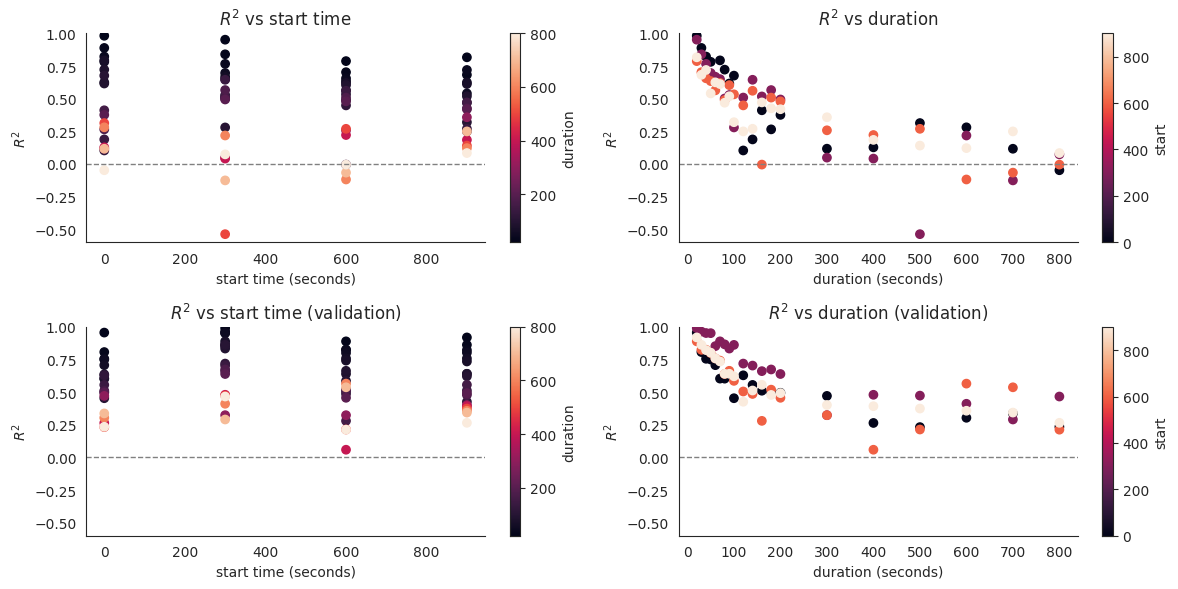

In [4]:
plt.figure(figsize=(12, 6))

plt.subplot(2, 2, 1)
scatter = plt.scatter(
    results["start"], results["rsquared"], marker="o", c=results["duration"]
)
plt.axhline(y=0, color="gray", linestyle="--", linewidth=1)
cbar = plt.colorbar(scatter, label="duration")
plt.xlabel("start time (seconds)")
plt.ylabel("$R^2$")
plt.ylim(-0.6, 1)
plt.title("$R^2$ vs start time")
sns.despine()
# plt.legend()

plt.subplot(2, 2, 2)
scatter2 = plt.scatter(
    results["duration"], results["rsquared"], marker="o", c=results["start"]
)
plt.axhline(y=0, color="gray", linestyle="--", linewidth=1)
cbar = plt.colorbar(scatter2, label="start")
plt.xlabel("duration (seconds)")
plt.ylabel("$R^2$")
plt.ylim(-0.6, 1)
plt.title("$R^2$ vs duration")
sns.despine()

plt.subplot(2, 2, 3)
scatter = plt.scatter(
    v_results["start"], v_results["v_rsquared"], marker="o", c=v_results["duration"]
)
plt.axhline(y=0, color="gray", linestyle="--", linewidth=1)
cbar = plt.colorbar(scatter, label="duration")
plt.xlabel("start time (seconds)")
plt.ylabel("$R^2$")
plt.ylim(-0.6, 1)
plt.title("$R^2$ vs start time (validation)")
sns.despine()

plt.subplot(2, 2, 4)
scatter2 = plt.scatter(
    v_results["duration"], v_results["v_rsquared"], marker="o", c=v_results["start"]
)
plt.axhline(y=0, color="gray", linestyle="--", linewidth=1)
cbar = plt.colorbar(scatter2, label="start")
plt.xlabel("duration (seconds)")
plt.ylabel("$R^2$")
plt.ylim(-0.6, 1)
plt.title("$R^2$ vs duration (validation)")
sns.despine()

plt.tight_layout()
if not smoke_test:
    plt.savefig(os.path.join(root, "docs/figures/locust_ds_validation.png"))
plt.show()

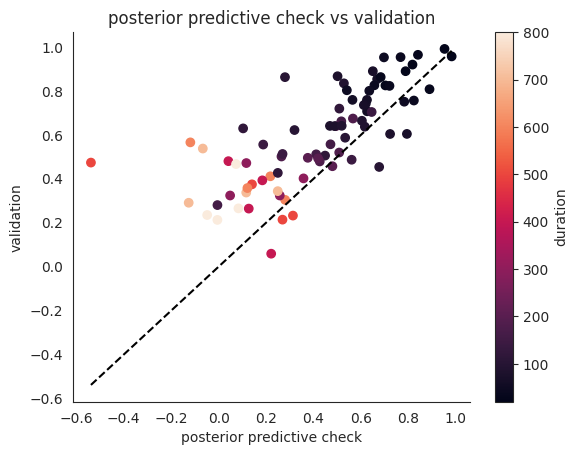

In [5]:
# note validation performance is slightly better, esp. for longer durations
# conjecture: the model slightly overfits early data and so loses performance esp. for longer durations

scatter = plt.scatter(
    y=v_results["v_rsquared"],
    x=results["rsquared"],
    marker="o",
    c=v_results["duration"],
)
plt.plot(
    [results["rsquared"].min(), results["rsquared"].max()],
    [results["rsquared"].min(), results["rsquared"].max()],
    color="black",
    linestyle="--",
)

plt.title("posterior predictive check vs validation")
plt.xlabel("posterior predictive check")
plt.ylabel("validation")
sns.despine()
plt.colorbar(scatter, label="duration")
plt.show()